## Inferencia de phishing en URLS.
## 1. Análisis de componentes principales PCA

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import sys
import joblib
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import plotly.io as pio
pio.renderers.default = 'png'
sys.path.append('..')

In [2]:
def apply_pca(X_scaled, n_components=None, variance_threshold=0.50):
    """
    Apply PCA to the scaled features.
    
    Parameters:
    - X_scaled: Scaled feature matrix
    - n_components: Number of components to keep (if None, use variance_threshold)
    - variance_threshold: Threshold of explained variance ratio to determine components
    
    Returns:
    - X_pca: Transformed features
    - pca: Fitted PCA object
    """
    if n_components is None:
        # Initialize PCA without specifying number of components
        pca = PCA()
        pca.fit(X_scaled)
        
        # Determine number of components based on explained variance
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
        print(f"Selected {n_components} components to explain {variance_threshold*100:.1f}% of variance")
        
        # Refit PCA with the determined number of components
        pca = PCA(n_components=n_components)
    else:
        pca = PCA(n_components=n_components)
    
    # Transform the data
    X_pca = pca.fit_transform(X_scaled)
    
    return X_pca, pca

In [3]:
def plot_explained_variance_plotly(pca):
    """
    Plot the explained variance ratio of PCA components using Plotly.
    """
    # Create data for the plot
    components = list(range(1, len(pca.explained_variance_ratio_) + 1))
    variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(variance_ratio)
    
    # Create a figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add bar chart for individual explained variance
    fig.add_trace(
        go.Bar(x=components, y=variance_ratio, name="Explained Variance"),
        secondary_y=False,
    )
    
    # Add line chart for cumulative explained variance
    fig.add_trace(
        go.Scatter(x=components, y=cumulative_variance, name="Cumulative Variance", line=dict(color='red')),
        secondary_y=True,
    )
    
    # Set titles and labels
    fig.update_layout(
        title_text="Explained Variance by Principal Component",
        xaxis_title="Principal Component",
        hovermode="x unified",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    
    # Set y-axes titles
    fig.update_yaxes(title_text="Explained Variance Ratio", secondary_y=False)
    fig.update_yaxes(title_text="Cumulative Explained Variance", secondary_y=True)
    
    # Add horizontal line at common variance thresholds
    for threshold in [0.25, 0.5, 0.75, 0.95]:
        fig.add_hline(y=threshold, line=dict(color="green", width=1, dash="dash"), 
                     annotation_text=f"{threshold*100}%", annotation_position="right",
                     secondary_y=True)
    
    return fig

In [4]:
def plot_feature_contributions_plotly(pca, feature_names, n_top_features=10):
    """
    Plot the feature contributions to principal components using Plotly.
    """
    # Create figures for top components
    n_components = min(2, pca.n_components_)
    figures = []
    
    for i in range(n_components):
        component = pca.components_[i]
        
        # Get indices of top contributing features (by absolute value)
        top_indices = np.argsort(np.abs(component))[::-1][:n_top_features]
        
        # Extract feature names and contribution values
        features = [feature_names[idx] for idx in top_indices]
        contributions = component[top_indices]
        
        # Create horizontal bar chart
        fig = go.Figure()
        
        # Add bars colored by contribution direction (positive/negative)
        colors = ['blue' if x >= 0 else 'red' for x in contributions]
        
        fig.add_trace(go.Bar(
            y=features,
            x=contributions,
            orientation='h',
            marker_color=colors
        ))
        
        # Set titles and labels
        fig.update_layout(
            title=f"Top Features Contributing to Principal Component {i+1}",
            xaxis_title="Component Coefficient",
            yaxis_title="Feature",
            yaxis=dict(autorange="reversed"),  # Reverse y-axis to show highest values at top
            height=500
        )
        
        figures.append(fig)
    
    return figures

In [5]:
def plot_pca_2d_plotly(X_pca, y, pca, feature_names):
    """
    Plot the first two PCA components with class labels and feature vectors using Plotly.
    
    Parameters:
    - X_pca: PCA transformed data
    - y: Target labels
    - pca: Fitted PCA object
    - feature_names: List of original feature names
    """
    if X_pca.shape[1] < 2:
        print("Not enough components for 2D visualization")
        return None
    
    # Create a DataFrame for plotting
    df_plot = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'Class': y
    })
    
    # Map class labels to meaningful names
    df_plot['Class_Label'] = df_plot['Class'].map({0: 'Legitimate', 1: 'Phishing'})
    
    # Create scatter plot for data points
    fig = px.scatter(
        df_plot, 
        x='PC1', 
        y='PC2', 
        color='Class_Label',
        color_discrete_map={'Legitimate': 'blue', 'Phishing': 'red'},
        opacity=0.7,
        title="PCA Biplot: First Two Principal Components",
        labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'},
        hover_data=['Class_Label']
    )
    
    # Add feature vectors
    # Scale the feature vectors for better visualization
    scale_factor = 0.5 * min(
        np.ptp(X_pca[:, 0]),  # range of PC1
        np.ptp(X_pca[:, 1])   # range of PC2
    )
    
    # Get top 10 features by contribution magnitude
    top_features = 10
    feature_contributions = np.sqrt(
        pca.components_[0]**2 + pca.components_[1]**2
    )
    top_indices = np.argsort(feature_contributions)[-top_features:]
    
    # Add arrows for each top feature
    for idx in top_indices:
        x = pca.components_[0, idx] * scale_factor
        y = pca.components_[1, idx] * scale_factor
        
        fig.add_annotation(
            x=x, y=y,
            ax=0, ay=0,
            xref="x", yref="y",
            axref="x", ayref="y",
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="black"
        )
        
        # Add feature name label
        fig.add_annotation(
            x=x, y=y,
            text=feature_names[idx],
            showarrow=False,
            font=dict(size=10),
            xanchor="left" if x > 0 else "right",
            yanchor="bottom"
        )
    
    # Update layout
    fig.update_layout(
        legend_title="Class",
        height=600, 
        width=800,
        showlegend=True
    )
    
    return fig

In [6]:
def train_logistic_regression(X_train, X_test, y_train, y_test):
    """
    Train a logistic regression model on PCA-transformed data.
    
    Returns:
    - model: Trained logistic regression model
    - performance: Dictionary with performance metrics
    """
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    performance = {
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    return model, performance

In [7]:
def plot_roc_curve_plotly(y_test, y_pred_proba):
    """
    Plot the ROC curve for the logistic regression model using Plotly.
    """
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create figure
    fig = go.Figure()
    
    # Add ROC curve
    fig.add_trace(go.Scatter(
        x=fpr, 
        y=tpr,
        mode='lines',
        name=f'ROC Curve (AUC = {auc:.3f})',
        line=dict(color='blue', width=2)
    ))
    
    # Add random classifier line
    fig.add_trace(go.Scatter(
        x=[0, 1], 
        y=[0, 1],
        mode='lines',
        name='Random Classifier',
        line=dict(color='gray', width=2, dash='dash')
    ))
    
    # Update layout
    fig.update_layout(
        title='ROC Curve - Logistic Regression on PCA Features',
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        legend=dict(x=0.7, y=0.1),
        width=700,
        height=500,
        xaxis=dict(range=[0, 1], constrain='domain'),
        yaxis=dict(range=[0, 1], constrain='domain'),
        showlegend=True
    )
    
    return fig

In [8]:
def plot_confusion_matrix_plotly(confusion_mat):
    """
    Plot the confusion matrix using Plotly.
    """
    # Define labels
    labels = ['Legitimate', 'Phishing']
    
    # Create annotation text
    annotations = []
    for i in range(len(confusion_mat)):
        for j in range(len(confusion_mat[i])):
            annotations.append(
                dict(
                    x=j,
                    y=i,
                    text=str(confusion_mat[i, j]),
                    font=dict(color='white' if confusion_mat[i, j] > confusion_mat.max()/2 else 'black', size=14),
                    showarrow=False
                )
            )
    
    # Create heatmap
    fig = go.Figure(data=go.Heatmap(
        z=confusion_mat,
        x=labels,
        y=labels,
        colorscale='Blues',
    ))
    
    # Add annotations
    fig.update_layout(
        title='Confusion Matrix - Logistic Regression on PCA Features',
        xaxis_title='Predicted Label',
        yaxis_title='True Label',
        xaxis=dict(side='bottom'),
        annotations=annotations,
        width=600,
        height=500
    )
    
    return fig 

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

def load_and_preprocess_data(file_path):
    """
    Load and preprocess the phishing dataset for machine learning.
    """
    # Load the data
    df = pd.read_csv(file_path)
    
    # Separate features and target
    X = df.drop(['label', 'FILENAME', 'URL', 'Domain', 'Title'], axis=1)
    y = df['label']
    
    # Convert boolean columns to int
    boolean_columns = X.select_dtypes(include=['bool']).columns
    X[boolean_columns] = X[boolean_columns].astype(int)
    
    # Handle categorical columns
    categorical_columns = X.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    
    # Scale numerical features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert back to DataFrame to maintain column names
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X_scaled, y

def prepare_inference_data(file_path, scaler=None, label_encoders=None):
    """
    Prepare new data for inference using the same preprocessing steps.
    """
    # Load the data
    df = pd.read_csv(file_path)
    
    # Separate features
    X = df.drop(['FILENAME', 'URL', 'Domain', 'Title'], axis=1, errors='ignore')
    
    # Convert boolean columns to int
    boolean_columns = X.select_dtypes(include=['bool']).columns
    X[boolean_columns] = X[boolean_columns].astype(int)
    
    # Handle categorical columns
    categorical_columns = X.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if label_encoders and col in label_encoders:
            X[col] = label_encoders[col].transform(X[col].astype(str))
        else:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            if label_encoders is not None:
                label_encoders[col] = le
    
    # Scale numerical features
    if scaler:
        X_scaled = scaler.transform(X)
    else:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    
    # Convert back to DataFrame
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X_scaled, scaler, label_encoders

def save_preprocessing_artifacts(scaler, label_encoders, output_dir='artifacts'):
    """
    Save preprocessing artifacts for later use in inference.
    """
    import joblib
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save scaler
    joblib.dump(scaler, os.path.join(output_dir, 'scaler.joblib'))
    
    # Save label encoders
    for col, le in label_encoders.items():
        joblib.dump(le, os.path.join(output_dir, f'label_encoder_{col}.joblib'))

def load_preprocessing_artifacts(input_dir='artifacts'):
    """
    Load preprocessing artifacts for inference.
    """
    import joblib
    import os
    
    # Load scaler
    scaler = joblib.load(os.path.join(input_dir, 'scaler.joblib'))
    
    # Load label encoders
    label_encoders = {}
    for file in os.listdir(input_dir):
        if file.startswith('label_encoder_'):
            col = file.replace('label_encoder_', '').replace('.joblib', '')
            label_encoders[col] = joblib.load(os.path.join(input_dir, file))
    
    return scaler, label_encoders

## Cargamos y pre-procesamos los datos. PCA necesita variables con media cero y varianza unitaria.
## Tiramos las columnas 'titulo, url, domain, Title' porque básicamente sus valores son únicos
## y lo importante de la URL ya está capturado en las otras features.

In [10]:
# Create output directories
os.makedirs('../plots', exist_ok=True)
os.makedirs('../pca_results', exist_ok=True)
os.makedirs('../artifacts', exist_ok=True)

# Load and preprocess data
file_path = '../../Data/Raw/PhiUSIIL_Phishing_URL_Dataset.csv'
X_scaled, y = load_and_preprocess_data(file_path)

# Save preprocessing artifacts for later use
# Create a scaler and fit it to the data
scaler = StandardScaler()
scaler.fit(X_scaled)

# Create empty label encoders dictionary
label_encoders = {}

# Read the original data to get categorical columns
df = pd.read_csv(file_path)
X = df.drop(['label', 'FILENAME', 'URL', 'Domain', 'Title'], axis=1)
categorical_columns = X.select_dtypes(include=['object']).columns

# Create label encoders for each categorical column
for col in categorical_columns:
    le = LabelEncoder()
    le.fit(X[col].astype(str))
    label_encoders[col] = le

# Save the preprocessing artifacts
save_preprocessing_artifacts(scaler, label_encoders)

print("Original data shape:", X_scaled.shape)

Original data shape: (235795, 51)


In [11]:
# Apply PCA (automatically determine number of components)
variance_threshold = 0.75  # Explain 75% of variance
X_pca, pca = apply_pca(X_scaled, variance_threshold=variance_threshold)

print("PCA transformed data shape:", X_pca.shape)
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Selected 20 components to explain 75.0% of variance
PCA transformed data shape: (235795, 20)
Explained variance ratio: [0.17995189 0.09808057 0.05412036 0.04345818 0.03675129 0.03558306
 0.03126925 0.02930828 0.02716744 0.02425956 0.02271439 0.02210836
 0.02152702 0.02041419 0.01974596 0.01948561 0.01900047 0.01860953
 0.01709787 0.01651003]


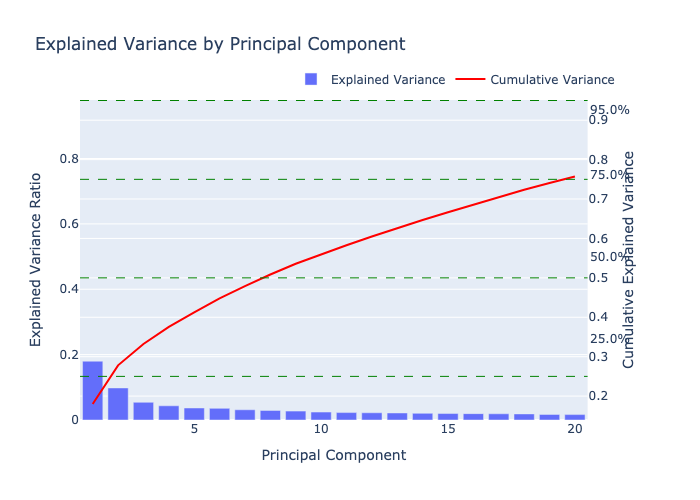

In [12]:
# Plot explained variance
fig1 = plot_explained_variance_plotly(pca)
fig1.show()

## Se requieren 20 componentes para llegar a 75% de varianza explicada.
## Sin embargo se puede ver un quiebre del segundo al tercer componente.
## Por la regla del codo (y por simplicidad) intentemos trabajar con 2 componentes principales.

## Vamos a tratar de describir los componentes.

Top features contributing to PC1:


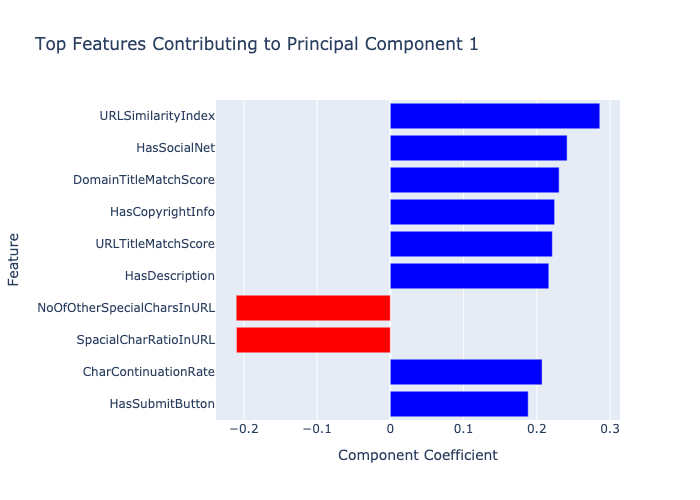

Top features contributing to PC2:


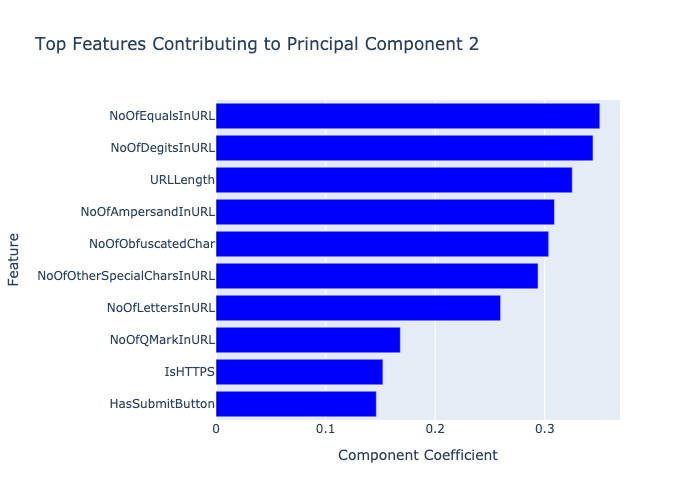

In [13]:
# Plot feature contributions
figs_contributions = plot_feature_contributions_plotly(pca, X_scaled.columns)
for i, fig in enumerate(figs_contributions):
    print(f"Top features contributing to PC{i+1}:")
    fig.show()

## Interpretación de los factores principales


### El factor 1 tiene que ver con legitimidad de la página,
###  qué tan similar es a páginas legítimas, y si posee otros marcadores de autenticidad
### de ser auténtica como CopyRightInfo, si tiene links a redes sociales, similitud a páginas legítimas.
### Cuanto mayor tiene caracteres especiales en la URL, menor es legítima.

### El factor 2 es básicamente el análisis léxico estático de la URL para ofuscación
### Captura la intención maliciosa del atacante al alterar la URL al incluir muchos caracteres, muchos digitos, signos 
### de redirección, de query params, botones para mandar forms. 

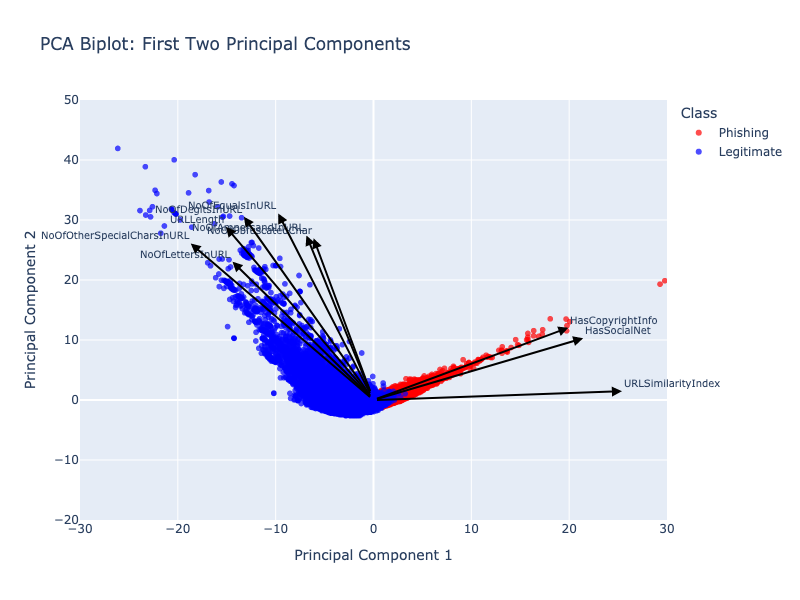

In [14]:
# Plot PCA 2D visualization
fig_2d = plot_pca_2d_plotly(X_pca, y, pca, feature_names=X.columns)
fig_2d.update_layout(
    xaxis=dict(range=[-30, 30]),
    yaxis=dict(range=[-20, 50])
)

fig_2d.show()

## Notamos que los datos están bien separados en las direcciones principales
## Lo que significa que hemos capturado una parte de la esencia del phishing con estas dos componentes
## Sin embargo se empalman muy cerca del origen lo cual quiere decir que hay muestras
## Indistinguibles usando las 2 primera componentes.


## 2. Ahora entrenamos un modelo de regresión logística
## Usando X_PCA con tres componentes

### Este es un caso de clasificación en donde las clases no están balanceadas
### Además de eso, error t2 (decir que es benigno cuando es phishing) puede ser
### muy costoso para el usuario. Por lo que una métrica como accuracy no es buena.
### Podemos usar F1 que balancea precisión y recall.
### Y también veremos área bajo la curva de ROC.

In [15]:
X_pca.size

4715900

In [16]:
# Split data for training
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Train logistic regression model
model, performance = train_logistic_regression(X_train, X_test, y_train, y_test)

print("Classification Report:")
print(performance['classification_report'])
print(f"ROC AUC Score: {performance['roc_auc']:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159

ROC AUC Score: 1.000


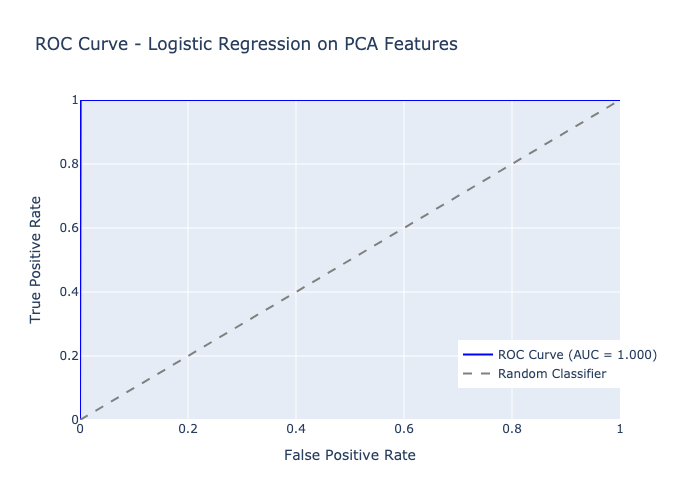

In [17]:
# Plot ROC curve
fig_roc = plot_roc_curve_plotly(y_test, model.predict_proba(X_test)[:, 1])
fig_roc.show()

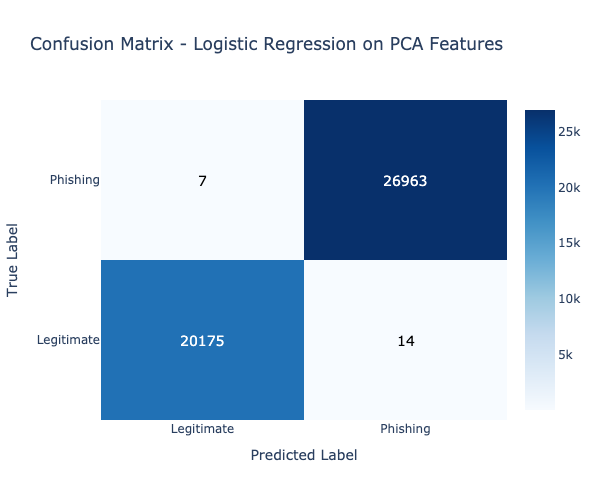

In [18]:
# Plot confusion matrix
fig_cm = plot_confusion_matrix_plotly(performance['confusion_matrix'])
fig_cm.show()

## De la matriz de confusión notamos que hubo 21 equivocaciones de los 47000 ejemplos.

## Vemos que no importa qué métrica usemos, realmente todas van a tener cercanas a 1.
## No es tan importante la métrica de evaluación, F1, recall, sensitivity, accuracy...

In [19]:
# Write top feature contributions to file
with open('../pca_results/top_features_plotly.txt', 'w') as f:
    f.write("# Top Features Contributing to Principal Components\n\n")
    for i in range(min(3, pca.n_components_)):
        component = pca.components_[i]
        # Get indices of top contributing features
        top_indices = np.argsort(np.abs(component))[::-1][:10]
        
        f.write(f"## Principal Component {i+1}\n")
        for idx in top_indices:
            feature = X_scaled.columns[idx]
            contribution = component[idx]
            f.write(f"{feature}: {contribution:.4f}\n")
        f.write("\n")

In [20]:
# Save results
os.makedirs('../pca_results', exist_ok=True)

# Save model and PCA transformer
joblib.dump(model, '../pca_results/logistic_regression_model_plotly.joblib')
joblib.dump(pca, '../pca_results/pca_transformer_plotly.joblib')

# Save performance metrics to text file
with open('../pca_results/performance_metrics_plotly.txt', 'w') as f:
    f.write("# Logistic Regression on PCA Features - Performance Metrics\n\n")
    f.write("## Classification Report\n")
    f.write(performance['classification_report'])
    f.write("\n\n## ROC AUC Score\n")
    f.write(f"ROC AUC: {performance['roc_auc']:.3f}\n")

print("\nPCA analysis and Logistic Regression completed!")
print(f"Explained variance with {pca.n_components_} components: {np.sum(pca.explained_variance_ratio_):.3f}")
print(f"Logistic Regression ROC AUC: {performance['roc_auc']:.3f}")
print("\nResults saved to ../pca_results/ directory")


PCA analysis and Logistic Regression completed!
Explained variance with 20 components: 0.757
Logistic Regression ROC AUC: 1.000

Results saved to ../pca_results/ directory


## Hacemos algunas predicciones con el modelo.

In [21]:
def predict_with_pca_model(data_path, pca_model_path='../pca_results/pca_transformer_plotly.joblib', 
                          lr_model_path='../pca_results/logistic_regression_model_plotly.joblib'):
    """
    Make predictions using the PCA-transformed logistic regression model.
    
    Parameters:
    - data_path: Path to the input data CSV
    - pca_model_path: Path to the saved PCA transformer
    - lr_model_path: Path to the saved logistic regression model
    
    Returns:
    - DataFrame with URLs and predictions
    """
    # Load original data
    original_data = pd.read_csv(data_path)
    
    # Use the same preprocessing function used during training
    X_scaled, _ = load_and_preprocess_data(data_path)
    
    # Load PCA transformer and logistic regression model
    pca = joblib.load(pca_model_path)
    model = joblib.load(lr_model_path)
    
    # Transform data using PCA
    X_pca = pca.transform(X_scaled)
    
    # Make predictions
    predictions = model.predict(X_pca)
    prediction_probas = model.predict_proba(X_pca)[:, 1]
    
    # Create results DataFrame
    results = pd.DataFrame({
        'URL': original_data['URL'],
        'Prediction': predictions,
        'Phishing_Probability': prediction_probas
    })
    
    # Map predictions to labels
    results['Prediction'] = results['Prediction'].map({0: 'Legitimate', 1: 'Phishing'})
    
    return results

In [22]:
# Example of making predictions with the model
test_file = '../../Data/Raw/PhiUSIIL_Phishing_URL_Dataset.csv'  # For demonstration, using same file
results = predict_with_pca_model(test_file)
print(f"Predictions summary: {results['Prediction'].value_counts().to_dict()}")
print("Sample predictions:")
display(results.head(100))  # Using display for better table formatting in Jupyter 

Predictions summary: {'Phishing': 134908, 'Legitimate': 100887}
Sample predictions:


,URL,Prediction,Phishing_Probability
0,https://www.southbankmosaics.com,Phishing,1.000000
1,https://www.uni-mainz.de,Phishing,1.000000
2,https://www.voicefmradio.co.uk,Phishing,0.999988
3,https://www.sfnmjournal.com,Phishing,1.000000
4,https://www.rewildingargentina.org,Phishing,1.000000
...,...,...,...
95,https://www.nutritioncare.org,Phishing,1.000000
96,https://www.tileandstonejournal.com,Phishing,1.000000
97,https://www.c.line-design.fr,Phishing,1.000000
98,https://www.capeblancoheritagesociety.com,Phishing,0.997895


In [23]:
# Find incorrect predictions by comparing with ground truth
# Load the original dataset to get ground truth labels
original_data = pd.read_csv(test_file)
ground_truth = original_data['label'].map({0: 'Legitimate', 1: 'Phishing'})

# Create a comparison dataframe
comparison = pd.DataFrame({
    'URL': results['URL'],
    'Ground_Truth': ground_truth,
    'Prediction': results['Prediction'],
    'Phishing_Probability': results['Phishing_Probability']
})

# Find incorrect predictions
incorrect_predictions = comparison[comparison['Ground_Truth'] != comparison['Prediction']]

print(f"\nFound {len(incorrect_predictions)} incorrect predictions")
print("\nIncorrect predictions:")
display(incorrect_predictions)



Found 112 incorrect predictions

Incorrect predictions:


,URL,Ground_Truth,Prediction,Phishing_Probability
7535,https://www.sharestion.com,Legitimate,Phishing,0.625040
9335,http://www.jiazheng369.com,Legitimate,Phishing,0.743959
11511,http://www.dwwmaster.com,Legitimate,Phishing,0.831163
12358,http://www.ifin.ru,Legitimate,Phishing,0.968545
13987,https://avlesbian.com/,Legitimate,Phishing,0.532702
...,...,...,...,...
225512,http://www.one-it.com,Legitimate,Phishing,0.553876
225675,http://www.armandonieto.com,Legitimate,Phishing,0.757353
225966,http://www.ssquid.net,Legitimate,Phishing,0.801322
233839,https://www.rajabandarjudi.org,Phishing,Legitimate,0.386710


## Notamos que tenemos 112 predicciones incorrectas, son extremadamente pocas.
## Pero investiguemos porqué sucede esto y en qué podría mejorar el modelo.


Found 8 predictions with probabilities close to 0.5 (±0.01)

Uncertain predictions:


,URL,Prediction,Phishing_Probability
71925,https://www.unionbindinqcompany.it,Legitimate,0.494129
97385,https://www.listography.com,Legitimate,0.497100
83051,https://www.thenaijatimes.com,Legitimate,0.498129
145983,https://candacleaning.com/,Legitimate,0.499784
174446,https://www.direct.smbc.co.jp.tsbxg.top,Legitimate,0.499805
173985,http://www.friendsfirst.online,Phishing,0.502441
219631,https://www.box-to-box.app,Phishing,0.502454
135253,https://www.fuchs-auf-dux.li,Phishing,0.505194


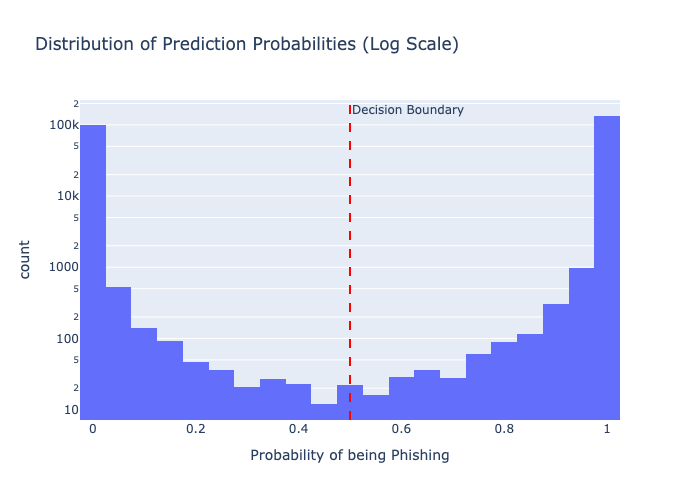

In [24]:
# Find predictions with probabilities close to 0.5 (uncertain predictions)
uncertain_threshold = 0.01  # Define threshold for "close to 0.5"
uncertain_predictions = results[
    (results['Phishing_Probability'] >= 0.5 - uncertain_threshold) & 
    (results['Phishing_Probability'] <= 0.5 + uncertain_threshold)
].sort_values('Phishing_Probability')

print(f"\nFound {len(uncertain_predictions)} predictions with probabilities close to 0.5 (±{uncertain_threshold})")
print("\nUncertain predictions:")
display(uncertain_predictions)

# Create a histogram of prediction probabilities with log scale for y-axis
fig = px.histogram(
    results, 
    x='Phishing_Probability',
    nbins=50,
    title='Distribution of Prediction Probabilities (Log Scale)',
    labels={'Phishing_Probability': 'Probability of being Phishing', 'count': 'Number of URLs'}
)
fig.update_layout(yaxis_type="log")  # Set y-axis to logarithmic scale
fig.add_vline(x=0.5, line_dash="dash", line_color="red", annotation_text="Decision Boundary")
fig.show()


## La distribución de la certidumbre del modelo es buena, hay pocos elementos cerca del 0.5 y la densidad está concentrada
## En los extremos.


Found 27 type 2 errors (false negatives)

Type 2 errors (predicted legitimate but actually phishing):


,URL,Ground_Truth,Prediction,Phishing_Probability
15604,https://www.crookedlakereview.com,Phishing,Legitimate,0.432763
24887,https://www.privacyisawesome.com,Phishing,Legitimate,0.384224
39542,https://www.davidpratt.info,Phishing,Legitimate,0.406298
44702,https://www.phash.org,Phishing,Legitimate,0.488503
53302,https://www.emojitracker.com,Phishing,Legitimate,0.438949
54507,https://www.whiskyforeveryone.com,Phishing,Legitimate,0.476829
58211,https://www.remote-access-tool.at,Phishing,Legitimate,0.331868
67328,https://www.sidneyolcott.com,Phishing,Legitimate,0.323135
67534,https://www.cartes-voeux-flash.fr,Phishing,Legitimate,0.213613
73660,https://www.churchaware.com,Phishing,Legitimate,0.034694



Confusion Matrix:


Prediction,Legitimate,Phishing,All
Ground_Truth,,,
Legitimate,100860,85,100945
Phishing,27,134823,134850
All,100887,134908,235795



Type 2 Error Rate: 0.02%


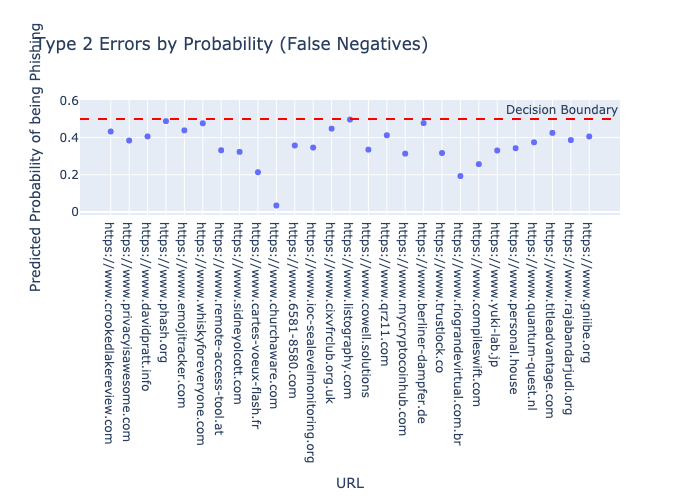

In [25]:
# Find incorrect predictions by comparing with ground truth
# Load the original dataset to get ground truth labels
original_data = pd.read_csv(test_file)
ground_truth = original_data['label'].map({0: 'Legitimate', 1: 'Phishing'})

# Create a comparison dataframe
comparison = pd.DataFrame({
    'URL': results['URL'],
    'Ground_Truth': ground_truth,
    'Prediction': results['Prediction'],
    'Phishing_Probability': results['Phishing_Probability']
})

# Find type 2 errors (false negatives) - predicted legitimate but actually phishing
type2_errors = comparison[
    (comparison['Ground_Truth'] == 'Phishing') & 
    (comparison['Prediction'] == 'Legitimate')
]

print(f"\nFound {len(type2_errors)} type 2 errors (false negatives)")
print("\nType 2 errors (predicted legitimate but actually phishing):")
display(type2_errors)

# Create confusion matrix visualization
conf_matrix = pd.crosstab(
    comparison['Ground_Truth'], 
    comparison['Prediction'],
    margins=True
)
print("\nConfusion Matrix:")
display(conf_matrix)

# Calculate type 2 error rate
type2_error_rate = len(type2_errors) / len(comparison[comparison['Ground_Truth'] == 'Phishing']) * 100
print(f"\nType 2 Error Rate: {type2_error_rate:.2f}%")

# Create a scatter plot of type 2 errors
fig = px.scatter(
    type2_errors,
    x='URL',
    y='Phishing_Probability',
    title='Type 2 Errors by Probability (False Negatives)',
    labels={'Phishing_Probability': 'Predicted Probability of being Phishing'}
)
fig.add_hline(y=0.5, line_dash="dash", line_color="red", annotation_text="Decision Boundary")
fig.show()


## podemos ver que estos url parecen benignas, sobre todo churchwarare.com en donde la prob de phishing es casi 0.
## En algunos casos tenemos que nuestro modelo está cerca de la frontera 0.5, listography.com 0.497.
## En general no podemos decir que hay una falla fundamental en el modelo.

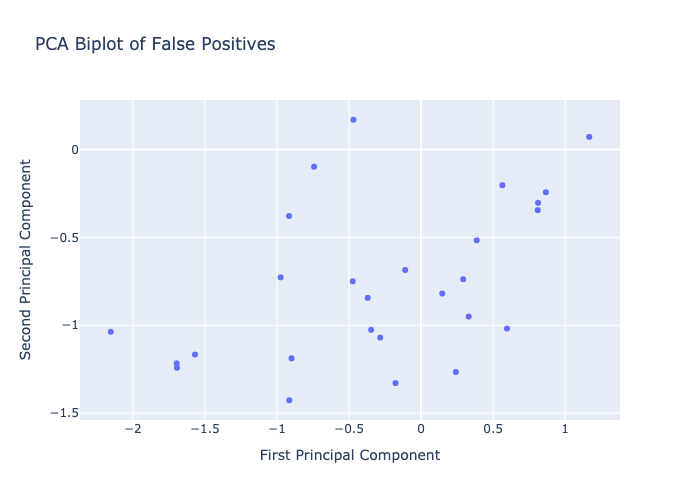

In [26]:
# Get PCA components for all data points
X_pca = pca.transform(X_scaled)

# Get indices of false positives (type 2 errors)
false_positive_indices = type2_errors.index

# Create a scatter plot of the first two PCA components for false positives only
fig = px.scatter(
    x=X_pca[false_positive_indices, 0],
    y=X_pca[false_positive_indices, 1],
    title='PCA Biplot of False Positives',
    labels={'x': 'First Principal Component', 'y': 'Second Principal Component'},
    hover_name=X.index[false_positive_indices]
)

fig.show()


## No podemos ver ningún patrón y las direcciones principales no son suficientes para decidir bien.

## En conclusión, nuestro predictor es altamente eficaz para clasificar URLs y detectar el phishing.
## Las direcciones principales capturan la esencia del phishing y se le da una interpretación al problema
## en términos de ciberseguridad. Si hicieramos un software como una extensión de chrome para detectar phishing
## podríamos tener éxito comercial.